## Module import
Loading necessary modules for the script to execute

In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import pandas as pd

/home/daqop/anaconda3/envs/deeprank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data pre-processing
Here we load the csv file and define main functions. Peptides are labeled as binders or not with a threshold of 500. Then peptides are one-hot encoded into a vector of size 20.

In [2]:
df = pd.read_csv("../../../../../../data/external/processed/BA_pMHCI.csv")
peptides = df["peptide"]
labels = [(0.,1.)[float(measurement) <= 500] for measurement in df["measurement_value"]] 
positives = [label for label in labels if label == 1.]
negatives = [label for label in labels if label == 0.]
print(f"Number of binders: {len(positives)}")
print(f"Number of non binders: {len(negatives)}")
print(f"Binders and non binders combined: {len(negatives)+len(positives)}")

labels = torch.tensor(labels).long()
def peptide2onehot(peptide):
    AA_eye = torch.eye(20, dtype=torch.float)
    aminoacids = ('ACDEFGHIKLMNPQRSTVWY')
    return torch.stack([AA_eye[aminoacids.index(res)] for res in peptide])


peptides_encoded = torch.stack([peptide2onehot(seq) for seq in peptides])

Number of binders: 3516
Number of non binders: 4210
Binders and non binders combined: 7726


## Separate train, validation and test dataset
The train dataset is used for the training of the model. Validation dataset allows to evaluate the performance of the model at a given epoch on a different dataset than the one used for learning. The test dataset assesses the accuracy of model's prediction.
Before spliting the initial dataset into several components, data is shuffled and splitted without redundancies.

In [3]:
# dataset proportions
train_p = 0.7
validation_p = 0.2
test_p = 0.1

# hyperparameters
neurons_per_layer = 200
batch = 64
epochs = 50

# other parameters:
device = ("cpu", "cuda")[torch.cuda.is_available()]

# make the dataset class:
class Peptides(Dataset):
    def __init__(self):
        self.peptides = peptides_encoded
        self.labels = labels
    def __getitem__(self,idx):
        return self.peptides[idx],self.labels[idx]
    def __len__(self):
        return len(self.peptides)

# datasets splitting
dataset_len = len(labels)
dataset_splits = torch.tensor([train_p*dataset_len, validation_p*dataset_len, test_p*dataset_len])
dataset_splits = torch.round(dataset_splits).int()
train, validation, test = random_split(Peptides(), dataset_splits)

# create the dataloaders iterators:
train_dataloader = DataLoader(train, batch_size=batch)
validation_dataloader = DataLoader(validation, batch_size=batch)
test_dataloader = DataLoader(test, batch_size=batch)


## Training the model
First, we define the neural network architecture of the multi layer perceptron (MLP). The MLP is made of 2 layers and `neurons_per_layer` number of neurons per layer. The loss function used is cross entropy, which measures the difference of entropy between an expected probability distribution and the model's. The optimizer is ADAM.

The train function allows to train the model for `e` number of `epoches`.

In [4]:
# create the MLP class
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(20*9, neurons_per_layer),
            nn.BatchNorm1d(neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, neurons_per_layer),
            nn.ReLU(),
            nn.Linear(neurons_per_layer, 2),
        )
    def forward(self, x):
        x = self.flatten(x)
        output = self.linear_relu_stack(x)
        return output

model = MLP().to(device)

# define the loss function and the optimizer:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# define the train function
def train(dataloader, model, loss_fn,optimizer):
    model.train()
    for X,y in dataloader:
        # forward propagation
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y)

        # backpropagation
        optimizer.zero_grad() # old gradient removed (Adam optimizer uses momentum but it is handled internally)
        loss.backward() # calculates the gradient by making derivatives 
        optimizer.step() # performs a single parameters update using the calculated gradient

#define the validation function
def evaluate(dataloader, model):
    predictions = torch.tensor([])
    model.eval()
    with torch.no_grad():
        labels = torch.tensor([])
        for X,y in dataloader:
            pred = model(X)
            predictions = torch.cat((predictions, pred.max(1)[1]), 0)
            labels = torch.cat((labels,y), 0)
    pos_rate = float((predictions.round() == labels).sum()/labels.size(0)*100)
    # neg_rate = float((predictions)/labels.size(0)*100)
    return pos_rate 

Now we train the model. At the end of each epoches we plot the PPV (positively predicted values) rate both for the training dataset and the validation dataset thus assessing the predictive and generalizing performances of the model.

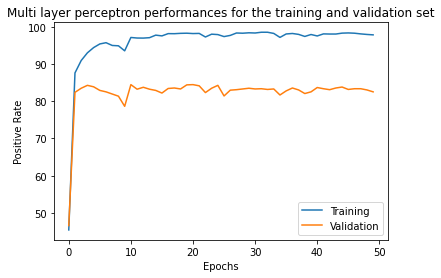

model's accuracy (based on test data): 82.92367553710938


In [5]:
train_pr = []
validation_pr = []
for e in range(epochs):
    train_positive = evaluate(train_dataloader, model)
    validation_positive = evaluate(validation_dataloader, model)
    train_pr.append(train_positive)
    validation_pr.append(validation_positive)
    train(train_dataloader, model, loss_fn, optimizer) #train on the whole database in batches
plt.plot(range(epochs), train_pr, label="Training")
plt.plot(range(epochs), validation_pr, label="Validation")
plt.legend(["Training", "Validation"])
plt.title("Multi layer perceptron performances for the training and validation set")
plt.xlabel("Epochs")
plt.ylabel("Positive Rate")
plt.show()
test_score = evaluate(test_dataloader, model)
print("model's accuracy (based on test data):", test_score)
    